In [1]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2
import random
# import torch.nn.functional as F
from torchvision.transforms import functional as F

In [ ]:
# !pip install --upgrade albumentations
# import albumentations as A

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## To Do: 

### Test Model on new things (Apple logo, different fruits etc.)
### Try doing solution 1 and then if not working then solution 2 (For Lable changing you can do it manually with code on the dataframe or something of that nature). 
### Use Metrics (from papers or something else that is popular) for object detection and integrate a test function. Can try to (Look at coco losses in pytorch code)
### Find Third party augmentations and make shift in code.

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
###### Label Data and put them in the csv file (might need to do this before training). 


##### Add to the spreadsheet by getting info about agencies or research that is to help people who suffer from blindness.


## Links 
* Model: 
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

* For Albumentations look at open source github
For Cropping 
https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/crops/transforms.py
https://github.com/albumentations-team/albumentations/blob/ae50578a46e5981eccaafee311a3ee0b4b7992b2/albumentations/augmentations/crops/functional.py#L22


# How to solve bad spots problem 
First run the fruit detector -> bouding box over every fruit. 
Then I will crop the image along the bouding box. 
Then run the cropped image through another bounding box detector and get object detection of bad_spots.

# Another solution 
Find Models that can work with neural network object detection crowding. 

#Another Solution
So I can remove the bad spot label and then have
["Apple", "Bad Apple", "Strawberry", "Bad Strawberry"] etc.

#Even another solution 
["Apple", "Specific Apple badspot"]
Like current model except differtiating against other black spots.

In [3]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Fruit Defects Dataset HalfWay.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
#For one strawberry batch please drop watermark rows
strawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/FreshStrawberryBatch3Labels.csv", header = None)
strawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberriesBatch2Labels.csv", header = None)
strawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/Strawberrybatch1.csv", header = None)
rottenApple_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch1Labeled/RottenAppleBatch1Labels.csv", header = None)
rottenApple_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApplesBatch2Labels.csv", header = None)
rottenApple_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/RottenApplesBatch3Labels.csv", header = None)
rottenStrawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch1RottenStrawBerryLabels/RottenStrawberriesBatch1Labels.csv", header = None)
rottenStrawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch2RottenStrawBerryLabels/RottenStrawBerryBatch2.csv", header = None)
rottenStrawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch3RottenStrawberrylabel/rottenStrawberryBtch3labels.csv", header = None)

strawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]

#Drop some watermark data for Fresh StrawBerry Batch 1 Labeled images [59, 9, 93]

# strawberry_csv_batch_1 = strawberry_csv_batch_1[Image_id not in ["FreshStrawberries59.jpeg, FreshStrawberries9.jpeg, FreshStrawberries93.jpeg"]]
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries59.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries9.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries93.jpeg"].index, inplace = True)
strawberry_csv_batch_1 = strawberry_csv_batch_1.reset_index(drop=True)

#Stack all the csv files together. 
list_of_all_dataframes = [strawberry_csv_batch_1, strawberry_csv_batch_2, strawberry_csv_batch_3, rottenApple_csv_batch_1, 
                          rottenApple_csv_batch_2, rottenApple_csv_batch_3, rottenStrawberry_csv_batch_1, rottenStrawberry_csv_batch_2, 
                          rottenStrawberry_csv_batch_3]
fruit_df = pd.concat(list_of_all_dataframes, ignore_index = True)

total_row_sum_check = 0 
for dataframe in list_of_all_dataframes:
  total_row_sum_check += dataframe.shape[0]
print("Checked total rows from all the dataframes combined: {}".format(total_row_sum_check))
assert total_row_sum_check == fruit_df.shape[0]
print("DataFrame shape: {}".format(fruit_df.shape))
print("Unique Fruit Labels {}".format(fruit_df["Fruit"].unique()))
print("Number of Unique Images {}".format(len(fruit_df["Image_id"].unique())))
  


Checked total rows from all the dataframes combined: 844
DataFrame shape: (844, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Bad_Spots']
Number of Unique Images 246


In [6]:
#Post Processing 
fruit_df = fruit_df[fruit_df["Image_id"] != "FreshStrawberries15.jpeg"]

In [7]:
bounding_box_dict = dict()
labels_dict = dict()
classes = ["Bad_Spots", "Strawberry", "Apples"]

for row_index in range(len(fruit_df)): 
  current_image_file = fruit_df.iloc[row_index]["Image_id"]
  if current_image_file not in bounding_box_dict:
    bounding_box_dict[current_image_file] = list()
    labels_dict[current_image_file] = list()
  bounding_box_dict[current_image_file].append(fruit_df.iloc[row_index, 1:5].to_list())
  labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

print(len(bounding_box_dict))
print(len(labels_dict))

245
245


## Class function + util functions

In [8]:
def ffile_path(image_id, full_image_file_paths):
  for image_path in full_image_file_paths:
    if image_id in image_path:
      return image_path

def find_area_bb(bb_coord):
  bb_coord = bb_coord.numpy()
  area_of_each_bb = list()
  for pair_of_coord in bb_coord:
    area_of_each_bb.append(
        (pair_of_coord[2] - pair_of_coord[0]) * (pair_of_coord[3] - pair_of_coord[1])
    )
  return torch.tensor(area_of_each_bb, dtype=torch.int32)

def convert_min_max(bb_coord):
  for pair_of_coord in bb_coord:
    pair_of_coord[2], pair_of_coord[3] = (pair_of_coord[0] + pair_of_coord[-2]), (pair_of_coord[1] + pair_of_coord[-1])
  return bb_coord

class FruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())
    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths)    
    img = Image.open(img_path).convert("RGB") ## No Image path sometimes
    boxes = convert_min_max(torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32))
    
    labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = find_area_bb(boxes)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    
    #Query about transforms for labels of images
    if self.transforms: 
      img, target = self.transforms(img, target)
    
    
    return img, target

  def __len__(self):
    return len(self.imgs_key)

In [9]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


# class RandomHorizontalFlip(object):
#     def __init__(self, prob):
#         self.prob = prob

#     def __call__(self, image, target):
#         if random.random() < self.prob:
#             _,  width = image.shape[-2:]
#             image = image.flip(-1)
#             #Can change entire list by altering internal lists
#             #Property only of lists of lists etc.
#             for bb_coord in target["boxes"]:
#               bb_coord[0], bb_coord[2] = (width - bb_coord[0]), (width - bb_coord[2])
#               #Reorder into min max format
#               if bb_coord[0] > bb_coord[2]:
#                 new_pair = list(bb_coord)
#                 new_pair[0], new_pair[2] = new_pair[2], new_pair[0]
#                 bb_coord = torch.as_tensor(new_pair)
            
            

#         return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

In [10]:
#Using this stack overflow (https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders)
#(Suppose for example, you want to create batches of a list of varying dimension tensors. The below code pads sequences with 0 until the maximum sequence size of the batch,)
#Collate_fn is a function that is used to process your batches before you pass it to dataloader. In my case since I have different sized images I need a way to stack batches b/c torch.stack won't work.
#So I use zip which can accept tensors of different lengths and make them stacked with the size of the lowest length list given. Therefore stacking all the images in a batch 
#Successfully unlike torch.stack and doing that processing to every batch makes collate_fn vital since I have different image sizes.

def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])
    # return tuple(zip(*batch))

np.random.seed(42)
torch.manual_seed(42)
batch_size = 20

def get_transform(train):
    transform = []
    transform.append(ToTensor())
    if train:
        transform.append(RandomHorizontalFlip(0.5))
    return Compose(transform)

train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transform(train = False))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn= collate_fn)

In [13]:
COLORS = [(255, 0, 0) for i in range(len(classes))]
COLORS[0] = (0, 0, 255)

def draw_boxes(boxes, labels, image):
    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[labels[i]], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

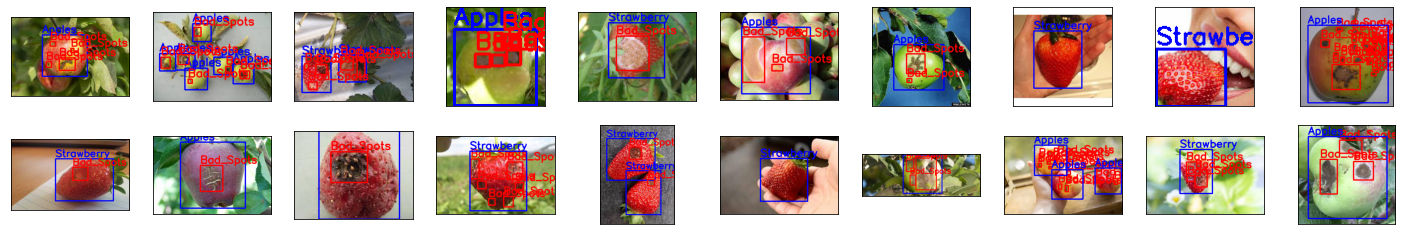

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = cv2.cvtColor(draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx]), cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [16]:
def train(net, epochs, train_loader, lr):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Check which parameters can calulate gradients. 
    params = [p for p in net.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr = lr)

    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    
    start_time = time.time()
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):

            images = [image.to(device) for image in images]
            targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

            optimizer.zero_grad()
            
            loss_dict = net(images, targets)
            losses = sum(loss for loss in loss_dict.values())
                
            losses.backward()
            optimizer.step()

            train_loss +=  losses.item()
        print("Epoch {} | Train_loss {:0.2f}".format(epoch + 1, train_loss))
    
    print("Time for Total Training {:0.2f}".format(time.time() - start_time))
    return net


## This link shows the problem https://github.com/pytorch/vision/issues/2740
The answer from @oke-aditya is correct. You are probably passing to the model bounding boxes in the format [xmin, ymin, width, height], while Faster R-CNN expects boxes to be in [xmin, ymin, xmax, ymax] format.

Changing this should fix the issue.

We have btw recently added box conversion utilities to torchvision (thanks to @oke-aditya ), they can be found in

Look at box convert or doing it locally also works.

### https://github.com/pytorch/vision/blob/a98e17e50146529cdfadb590ba063e6bbee71de2/torchvision/ops/boxes.py#L137-L156




In [17]:
import torchvision
backbone = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=False)
backbone.roi_heads.box_predictor.cls_score.out_features = 3
backbone.roi_heads.box_predictor.bbox_pred.out_features = 12

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


In [39]:
another_one = train(backbone, 30, train_loader, 0.001)

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Epoch 0 | Train_loss 8.80
Epoch 1 | Train_loss 4.75
Epoch 2 | Train_loss 4.44
Epoch 3 | Train_loss 3.79
Epoch 4 | Train_loss 3.57
Epoch 5 | Train_loss 3.24
Epoch 6 | Train_loss 2.98
Epoch 7 | Train_loss 3.06
Epoch 8 | Train_loss 2.70
Epoch 9 | Train_loss 2.77
Epoch 10 | Train_loss 2.63
Epoch 11 | Train_loss 2.83
Epoch 12 | Train_loss 2.46
Epoch 13 | Train_loss 2.37
Epoch 14 | Train_loss 2.45
Epoch 15 | Train_loss 2.23
Epoch 16 | Train_loss 2.81
Epoch 17 | Train_loss 2.76
Epoch 18 | Train_loss 2.79
Epoch 19 | Train_loss 2.24
Epoch 20 | Train_loss 2.12
Epoch 21 | Train_loss 2.16
Epoch 22 | Train_loss 2.20
Epoch 23 | Train_loss 2.16


KeyboardInterrupt: ignored

In [40]:
def infer_image(image_file_path, trained_model, distance_thresh, show_image = True):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Current device: {}".format(device))

  torch_image = F.to_tensor(Image.open(image_file_path).convert("RGB")).unsqueeze(0).to(device)
  trained_model.to(device)
  trained_model.eval()
  print("Image Size: {}".format(torch_image.size()))

  results = trained_model(torch_image)
  print(results)


  valid_box_count = 0
  for ii, score in enumerate(results[0]["scores"]):
    if score < distance_thresh:
      low_index_start = ii
      break
    else:
      valid_box_count += 1

  if valid_box_count == len(results[0]["scores"]):
    low_index_start = len(results[0]["scores"])
  

  for key in results[0]:
    results[0][key] = results[0][key][:low_index_start]

  if show_image:
    if device == torch.device("cuda"):
      torch_image = torch_image.cpu() 
    plt.imshow(cv2.cvtColor(draw_boxes(results[0]["boxes"], results[0]["labels"], torch_image.squeeze()), cv2.COLOR_BGR2RGB))
  
  return results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 991, 1600])
[{'boxes': tensor([[ 812.1453,  234.1095, 1329.7428,  813.9821],
        [ 230.8524,  337.0322,  577.2106,  710.3281],
        [ 518.4357,  607.2999,  862.1202,  910.4329],
        [ 188.9693,   30.0645,  430.6092,  256.6196],
        [ 415.8441,  641.1579,  799.9747,  982.9087]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9999, 0.9997, 0.9991, 0.9864, 0.0584], device='cuda:0',
       grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[ 812.1453,  234.1095, 1329.7428,  813.9821],
        [ 230.8524,  337.0322,  577.2106,  710.3281],
        [ 518.4357,  607.2999,  862.1202,  910.4329],
        [ 188.9693,   30.0645,  430.6092,  256.6196]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9999, 0.9997, 0.9991, 0.9864], device='cuda:0',
       grad_fn=<SliceBackward>)}]


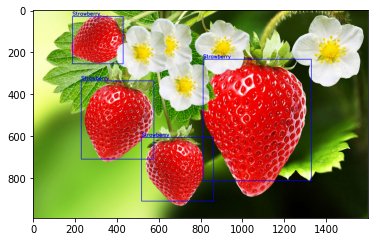

In [57]:
first_results = infer_image("/content/flower_straw.jpg", 
            another_one, 0.6)
print(first_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 194, 259])
[{'boxes': tensor([[121.3876,  93.3314, 213.3875, 178.2614],
        [ 81.4755,  25.9416, 165.5675, 104.1079],
        [ 16.9313,  82.2160, 116.4641, 170.7879],
        [ 19.5212,  81.6165,  81.2975, 153.2873],
        [  9.9703,  81.3892, 109.8850, 180.5804],
        [125.9089,  92.1035, 202.2680, 186.5817]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 2, 2], device='cuda:0'), 'scores': tensor([0.9988, 0.9986, 0.9960, 0.0595, 0.0595, 0.0544], device='cuda:0',
       grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[121.3876,  93.3314, 213.3875, 178.2614],
        [ 81.4755,  25.9416, 165.5675, 104.1079],
        [ 16.9313,  82.2160, 116.4641, 170.7879]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.9986, 0.9960], device='cuda:0', grad_fn=<SliceBackward>)}]


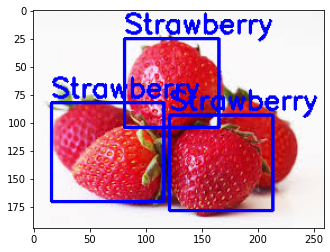

In [56]:
third_results = infer_image("/content/FreshStrawberries45.jpeg", 
            another_one, 0.6)
print(third_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 194, 259])
[{'boxes': tensor([[ 84.4970,  51.9675, 233.3775, 178.7050],
        [ 30.6007,  15.0120, 131.6817, 132.7550],
        [ 14.1730,  27.6625, 249.7487, 166.1217],
        [ 28.4198,  16.8518, 126.2217, 115.0877]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'scores': tensor([0.9996, 0.8725, 0.4265, 0.1808], device='cuda:0',
       grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[ 84.4970,  51.9675, 233.3775, 178.7050],
        [ 30.6007,  15.0120, 131.6817, 132.7550]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.8725], device='cuda:0', grad_fn=<SliceBackward>)}]


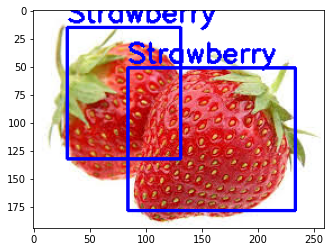

In [55]:
second_results = infer_image("/content/FreshStrawberries15.jpeg", 
            another_one, 0.6)
print(second_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 490, 490])
[{'boxes': tensor([[128.0931, 205.9171, 245.4345, 313.2629]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2525], device='cuda:0', grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[128.0931, 205.9171, 245.4345, 313.2629]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2525], device='cuda:0', grad_fn=<SliceBackward>)}]


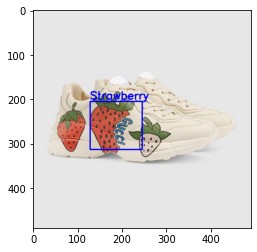

In [51]:
forth_results = infer_image("/content/starshoes.jpg", 
            another_one, 0.2)
print(forth_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 225, 225])
[{'boxes': tensor([[ 86.9815,  99.2368, 166.6633, 167.7584],
        [ 53.7187,  30.1602, 115.5922, 106.6664],
        [135.1551,  28.6095, 211.1995, 101.9994],
        [ 29.0835, 165.4526,  99.7865, 225.0000],
        [  2.6092,  90.1475,  71.9513, 154.4964],
        [138.2314,  31.6191, 210.7035,  98.1098]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 2, 2, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.9858, 0.9086, 0.8581, 0.3328, 0.3170], device='cuda:0',
       grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[ 86.9815,  99.2368, 166.6633, 167.7584],
        [ 53.7187,  30.1602, 115.5922, 106.6664],
        [135.1551,  28.6095, 211.1995, 101.9994],
        [ 29.0835, 165.4526,  99.7865, 225.0000]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([1, 2, 2, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.9858, 0.9086, 0.8581], device='cuda:0',
       grad_fn=<SliceBac

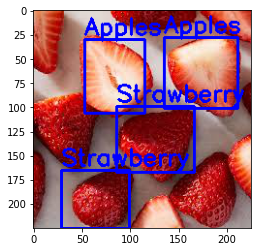

In [53]:
fifth_results = infer_image("/content/starwberyy.jpeg", 
            another_one, 0.6)
print(fifth_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 720, 1280])
[{'boxes': tensor([[  79.8518,  191.4039,  429.5078,  517.7314],
        [ 498.0799,  438.4593,  792.7394,  690.9084],
        [ 752.3782,  195.1261, 1111.9142,  487.0660],
        [ 639.3375,   57.6011,  929.2396,  338.2304],
        [ 387.9611,   51.4363,  652.7433,  266.5120],
        [ 612.4069,   52.9006, 1034.5992,  451.7052],
        [ 460.5476,  315.3092,  633.4808,  427.6295]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.9972, 0.9855, 0.9761, 0.7138, 0.6779, 0.3399],
       device='cuda:0', grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[  79.8518,  191.4039,  429.5078,  517.7314],
        [ 498.0799,  438.4593,  792.7394,  690.9084],
        [ 752.3782,  195.1261, 1111.9142,  487.0660],
        [ 639.3375,   57.6011,  929.2396,  338.2304],
        [ 387.9611,   51.4363,  652.7433,  266.5120],
        [ 612.4069,   52.9006, 1

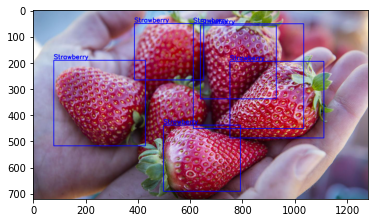

In [54]:
some_results1 = infer_image("/content/mant.jpg", 
            another_one, 0.6)
print(some_results1)

Current device: cuda
Image Size: torch.Size([1, 3, 2414, 2414])
[{'boxes': tensor([[ 855.6651,  589.6227, 2353.6387, 1787.2957],
        [ 160.1130,  860.9797, 1391.6517, 2109.0173],
        [   0.0000,  706.6516, 2207.0525, 1990.3239],
        [ 287.3911,  715.5330, 1081.7888, 1018.3841],
        [ 248.0866,  397.6693, 1118.7385, 1187.3054],
        [ 472.9294,  850.7903,  898.2991, 1060.0316],
        [ 897.7224,  663.9847, 2330.3215, 1641.0225]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([2, 2, 2, 2, 2, 2, 1], device='cuda:0'), 'scores': tensor([0.9869, 0.9815, 0.3698, 0.3259, 0.3152, 0.0657, 0.0584],
       device='cuda:0', grad_fn=<IndexBackward>)}]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[{'boxes': tensor([[ 855.6651,  589.6227, 2353.6387, 1787.2957],
        [ 160.1130,  860.9797, 1391.6517, 2109.0173]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([2, 2], device='cuda:0'), 'scores': tensor([0.9869, 0.9815], device='cuda:0', grad_fn=<SliceBackward>)}]


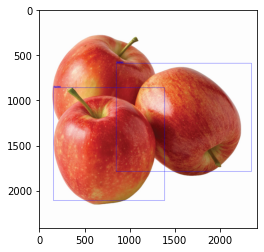

In [63]:
some_results2 = infer_image("/content/apples.webp", 
            another_one, 0.4)
print(some_results2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 750, 1000])
[{'boxes': tensor([[324.9996,  39.4011, 512.5583, 224.2451],
        [560.9155, 417.4235, 745.9505, 604.7656],
        [446.3468, 214.5541, 648.2576, 378.8253],
        [ 83.8219, 379.8676, 298.5799, 576.7324],
        [560.0463,  29.7039, 760.8395, 242.1419],
        [782.3502,  53.9031, 975.5167, 245.3980],
        [335.2772, 392.3058, 539.6319, 584.3503],
        [774.1115,  67.6306, 972.6635, 235.0608],
        [324.5182, 385.1139, 539.2509, 593.4129],
        [700.4011, 265.3087, 845.8771, 423.2062],
        [558.7443,  33.5335, 759.2551, 228.0376],
        [229.2258, 236.6062, 411.9127, 400.3809],
        [440.8143, 206.0098, 644.5828, 381.4063],
        [231.3583, 246.1264, 414.0664, 394.9052],
        [  3.7961, 202.8148, 191.5088, 358.4562],
        [333.3086,  34.3898, 513.2398, 222.6802],
        [ 80.3854, 377.6505, 298.0851, 574.4918]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([2, 2, 2

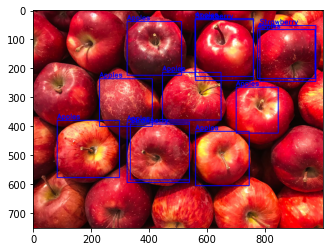

In [64]:
some_results3 = infer_image("/content/appssss.jpeg", 
            another_one, 0.3)
print(some_results3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 1390, 1300])
[{'boxes': tensor([[522.9932, 139.1312, 891.0934, 544.2504],
        [622.6377, 538.9714, 953.9552, 830.6551],
        [519.8232,   0.0000, 929.9192, 802.0632],
        [530.0650, 120.2013, 890.3030, 523.4661],
        [656.7432, 531.6811, 956.0648, 822.9838],
        [513.6415,   0.0000, 941.4258, 783.6360]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([2, 1, 2, 1, 2, 1], device='cuda:0'), 'scores': tensor([0.9217, 0.8235, 0.7694, 0.3468, 0.3107, 0.0606], device='cuda:0',
       grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[522.9932, 139.1312, 891.0934, 544.2504],
        [622.6377, 538.9714, 953.9552, 830.6551]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([2, 1], device='cuda:0'), 'scores': tensor([0.9217, 0.8235], device='cuda:0', grad_fn=<SliceBackward>)}]


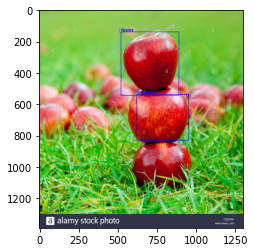

In [67]:
some_results4 = infer_image("/content/stacked_apples.jpg", 
            another_one, 0.8)
print(some_results4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 192, 262])
[{'boxes': tensor([[ 44.1744,  24.7514, 147.8973, 123.1020],
        [169.5682,  75.6350, 222.0268, 122.6508],
        [116.2445,  91.9498, 173.6719, 152.8303],
        [166.0912,  73.1518, 219.1408, 123.4317],
        [188.2389,  96.4267, 201.5286, 120.9532],
        [ 39.1835,  22.1832, 153.6111, 120.8095]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([2, 2, 2, 1, 2, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.9911, 0.9809, 0.1904, 0.1644, 0.0536], device='cuda:0',
       grad_fn=<IndexBackward>)}]


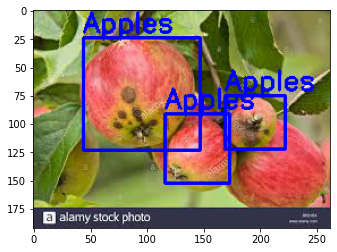

In [70]:
some_results4 = infer_image("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/Misfits/RottenApples105.jpeg", 
            another_one, 0.8)

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

#Got this code from Pytorch
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes= 3,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [ ]:
big_model_trained = train(model, 5, train_loader, 0.001)

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Train_loss 75.02
Train_loss 51.36
Train_loss 46.14
Train_loss 41.43
Train_loss 41.80
Time for Total Training 239.89
